<a href="https://colab.research.google.com/github/GoldenPandaMRW/KaggleCompetitions/blob/main/CNN_for_Digit_Recognition_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import pandas as pd
import torch # framework
import torch.nn as nn # neural net framework
import torchvision # dataset
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt # data visualization
from torchvision import transforms

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [15]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparamters = config of the model
input_size = 784 # images are 28x28
hidden_size = 100
num_classes = 10 # 0-9 digits
batch_size = 100

In [16]:
class DigitRecogDataset(Dataset):
    def __init__(self,csv_file,has_labels=True,transform=None):
        self.data = pd.read_csv(csv_file)
        self.has_labels = has_labels
        self.transform = transform

        if self.has_labels:
            # The first column of train.csv has labels for data
            self.labels = self.data.iloc[:,0].values
            self.images = self.data.iloc[:,1:].values
        else:
            # The test.csv does not contain a label
            self.images = self.data.values

    def __len__(self):
        return len(self.images)

    def __getitem__(self,index):
        image = self.images[index].reshape(28,28).astype('float32')/255.0
        image = torch.tensor(image).unsqueeze(0) # (1,28,28)

        if self.transform:
            image = self.transform(image)

        if self.has_labels:
            label = torch.tensor(self.labels[index],dtype=torch.long)
            return image, label
        else:
            return image

import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))  # normalize pixel values
])

In [17]:
# Dataset
from torch.utils.data import random_split, DataLoader

test_ds = DigitRecogDataset(
    csv_file="/content/test.csv",
    has_labels=False,
    transform=transform
)
train_ds = DigitRecogDataset(
    csv_file="/content/train.csv",
    has_labels=True,
    transform=transform
)

#split train_ds into a sperate validation set (val_ds)
#currently set to [10%] to give more data for training
val_frac = 0.1
n_val = int(len(train_ds) * val_frac)
n_train = len(train_ds) - n_val
train_ds, val_ds = random_split(train_ds, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds,batch_size=batch_size,shuffle=False)

torch.Size([100, 1, 28, 28]) torch.Size([100])


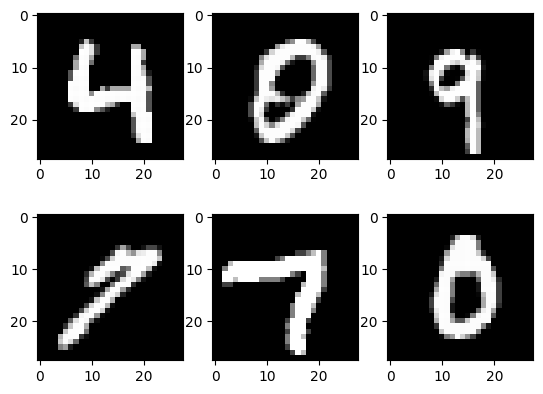

In [18]:
# visualize
examples = iter(train_loader)
samples, labels = next(examples) # torch objects have the samples and labels atributes
print(samples.shape, labels.shape)

# torch.Size([100, 1, 28, 28]) torch.Size([100])
# 100 samples, 1 channel of color, 28 width, 28 length
# Each class label has one value

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(samples[i][0], cmap='gray')
plt.show()

In [19]:
class MiniCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            # 1st convolution

            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # nn.ReLU(inplace=True) overwrites input tensor with ReLU() instead
            # of creating a new tensor and using more memory

            # 2nd convolution + MaxPool
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # pooling causes 28x28 --> 14x14
            nn.Dropout(0.10),

            # 3rd convolution
            nn.Conv2d(64,128,3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            #4th convolution
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # pooling causes 14x14 --> 7x7
            nn.Dropout(0.10),
        )

        # Global Average Pooling
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # [B, 128, 1, 1]
            nn.Flatten(), # [B, 128]
            nn.Linear(128, num_classes)
        )

        # Kaiming Init (Kaiming uniform distribution):
        # helps establish starting weights to prevent vanishing or blowup
        # of gradients and signals in backpropagation and forward propagation
        # respectively (prevent RNG from ruining model training)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return(x)

model = MiniCNN(num_classes=10)


In [20]:
# Training Loop
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

learning_rate = 1e-3
num_epochs = 30
n_steps = len(train_loader)

best_acc = 0.0
best_state = None

# Loss and Optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # applies softmax automatically
optimizer = AdamW(model.parameters(), lr = learning_rate, weight_decay = 1e-4)
model.to(device)

# Learning Rate Scheduler
scheduler = OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=num_epochs,
    steps_per_epoch=n_steps,
    pct_start=0.2, # warmup
    anneal_strategy='cos'
)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        # labels enter as [B,1,28,28]
        images = images.to(device)
        labels = labels.to(device)

    # forward propagation
        outputs = model(images)
        loss = criterion(outputs, labels) # predicted, actual

    # backward propagation
        optimizer.zero_grad() # empty gradients
        loss.backward() # backpropagation

    # gradient cliping (prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)

    # step
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()*labels.size(0)

    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds =  model(images).argmax(1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_acc = 100.0*(correct/total)

    if val_acc > best_acc:
        best_acc = val_acc
        best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}

    print(f"Epoch {epoch+1}/{num_epochs} | loss {running_loss/len(train_ds):.4f} | val {val_acc:.2f}%")

# load the current best model as a checkpoint
# saves only the best model for submission

if best_state:
    model.load_state_dict(best_state)
    model.to(device)

Epoch 1/30 | loss 1.6668 | val 82.10%
Epoch 2/30 | loss 0.8732 | val 95.98%
Epoch 3/30 | loss 0.6742 | val 97.02%
Epoch 4/30 | loss 0.6261 | val 98.10%
Epoch 5/30 | loss 0.6001 | val 97.26%
Epoch 6/30 | loss 0.5859 | val 97.95%
Epoch 7/30 | loss 0.5761 | val 98.52%
Epoch 8/30 | loss 0.5683 | val 98.83%
Epoch 9/30 | loss 0.5633 | val 98.02%
Epoch 10/30 | loss 0.5579 | val 98.10%
Epoch 11/30 | loss 0.5545 | val 98.93%
Epoch 12/30 | loss 0.5510 | val 99.14%
Epoch 13/30 | loss 0.5483 | val 98.98%
Epoch 14/30 | loss 0.5464 | val 99.10%
Epoch 15/30 | loss 0.5427 | val 99.26%
Epoch 16/30 | loss 0.5412 | val 99.19%
Epoch 17/30 | loss 0.5386 | val 99.14%
Epoch 18/30 | loss 0.5364 | val 99.19%
Epoch 19/30 | loss 0.5351 | val 99.38%
Epoch 20/30 | loss 0.5333 | val 99.36%
Epoch 21/30 | loss 0.5321 | val 99.29%
Epoch 22/30 | loss 0.5309 | val 99.31%
Epoch 23/30 | loss 0.5297 | val 99.29%
Epoch 24/30 | loss 0.5287 | val 99.38%
Epoch 25/30 | loss 0.5277 | val 99.24%
Epoch 26/30 | loss 0.5270 | val 99

In [21]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Validation accuracy: {100 * correct / total:.2f}%")


Validation accuracy: 98.00%


In [22]:
# Model Submission

model.eval()
predictions = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

submission = pd.DataFrame({
    "ImageID": range(1, len(predictions)+1),
    "Label": predictions
})

submission.to_csv("submission.csv", index=False)